In [17]:
library(tidyverse)
library(catboost)
library(h2o)
library(lightgbm)
library(pROC)
library(caret)
library(themis)
library(tidymodels)
library(embed)
# library(missForest)

In [2]:
#helper function for multiplot
# Multiple plot function
# 
# ggplot objects can be passed in ..., or to plotlist (as a list of ggplot objects)
# - cols:   Number of columns in layout
# - layout: A matrix specifying the layout. If present, 'cols' is ignored.
#
# If the layout is something like matrix(c(1,2,3,3), nrow=2, byrow=TRUE),
# then plot 1 will go in the upper left, 2 will go in the upper right, and
# 3 will go all the way across the bottom.
#
# http://www.cookbook-r.com/Graphs/Multiple_graphs_on_one_page_(ggplot2)/
#
multiplot <- function(..., plotlist=NULL, file, cols=1, layout=NULL) {
  library(grid)

  # Make a list from the ... arguments and plotlist
  plots <- c(list(...), plotlist)

  numPlots = length(plots)

  # If layout is NULL, then use 'cols' to determine layout
  if (is.null(layout)) {
    # Make the panel
    # ncol: Number of columns of plots
    # nrow: Number of rows needed, calculated from # of cols
    layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                    ncol = cols, nrow = ceiling(numPlots/cols))
  }

 if (numPlots==1) {
    print(plots[[1]])

  } else {
    # Set up the page
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

    # Make each plot, in the correct location
    for (i in 1:numPlots) {
      # Get the i,j matrix positions of the regions that contain this subplot
      matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

      print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                      layout.pos.col = matchidx$col))
    }
  }
}

options(repr.plot.width = 14, repr.plot.height = 8)

In [3]:
train <- read_csv("../input/jobathon-may-2021-credit-card-lead-prediction//train.csv")
test <- read_csv("../input//jobathon-may-2021-credit-card-lead-prediction//test.csv")
sample_sub <- read_csv("../input//jobathon-may-2021-credit-card-lead-prediction//sample_submission.csv")


── Column specification ────────────────────────────────────────────────────────
cols(
  ID = col_character(),
  Gender = col_character(),
  Age = col_double(),
  Region_Code = col_character(),
  Occupation = col_character(),
  Channel_Code = col_character(),
  Vintage = col_double(),
  Credit_Product = col_character(),
  Avg_Account_Balance = col_double(),
  Is_Active = col_character(),
  Is_Lead = col_double()
)



── Column specification ────────────────────────────────────────────────────────
cols(
  ID = col_character(),
  Gender = col_character(),
  Age = col_double(),
  Region_Code = col_character(),
  Occupation = col_character(),
  Channel_Code = col_character(),
  Vintage = col_double(),
  Credit_Product = col_character(),
  Avg_Account_Balance = col_double(),
  Is_Active = col_character()
)



── Column specification ────────────────────────────────────────────────────────
cols(
  ID = col_character(),
  Is_Lead = col_double()
)




In [4]:
train <- train %>% select(-ID) %>% mutate_if(is.character,as.factor) 
test <- test %>% select(-ID) %>% mutate_if(is.character,as.factor)

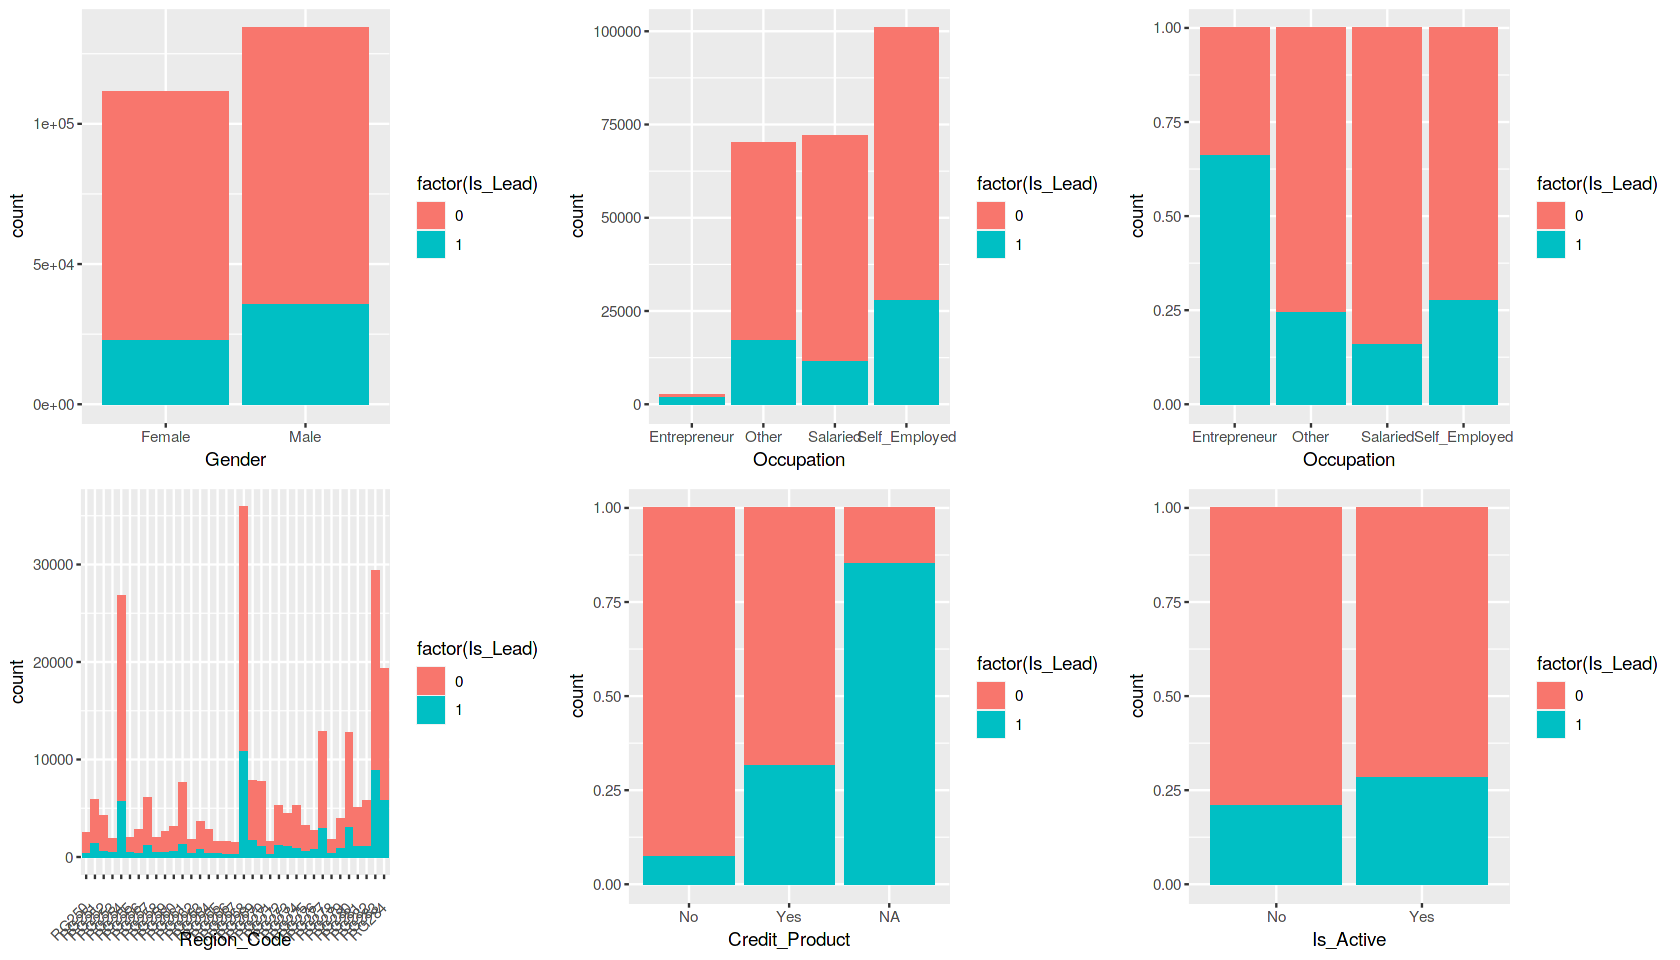

In [5]:
#Univariate Analysis
p1 <- train %>% ggplot(aes(Gender,fill=factor(Is_Lead)))+geom_bar(stat="count")
p2 <- train %>% ggplot(aes(Region_Code,fill=factor(Is_Lead)))+geom_bar(stat="count")+
theme(axis.text.x = element_text(angle = 45, vjust = 0.5, hjust=1))
p3 <- train %>% ggplot(aes(Occupation,fill=factor(Is_Lead)))+geom_bar(stat="count")
p4 <- train %>% ggplot(aes(Credit_Product,fill=factor(Is_Lead)))+geom_bar(stat="count",position="fill")
p5 <- train %>% ggplot(aes(Occupation,fill=factor(Is_Lead)))+geom_bar(stat="count",position="fill")
p6 <- train %>% ggplot(aes(Is_Active,fill=factor(Is_Lead)))+geom_bar(stat="count",position="fill")
multiplot(p1, p2, p3, p4, p5, p6, cols=3)

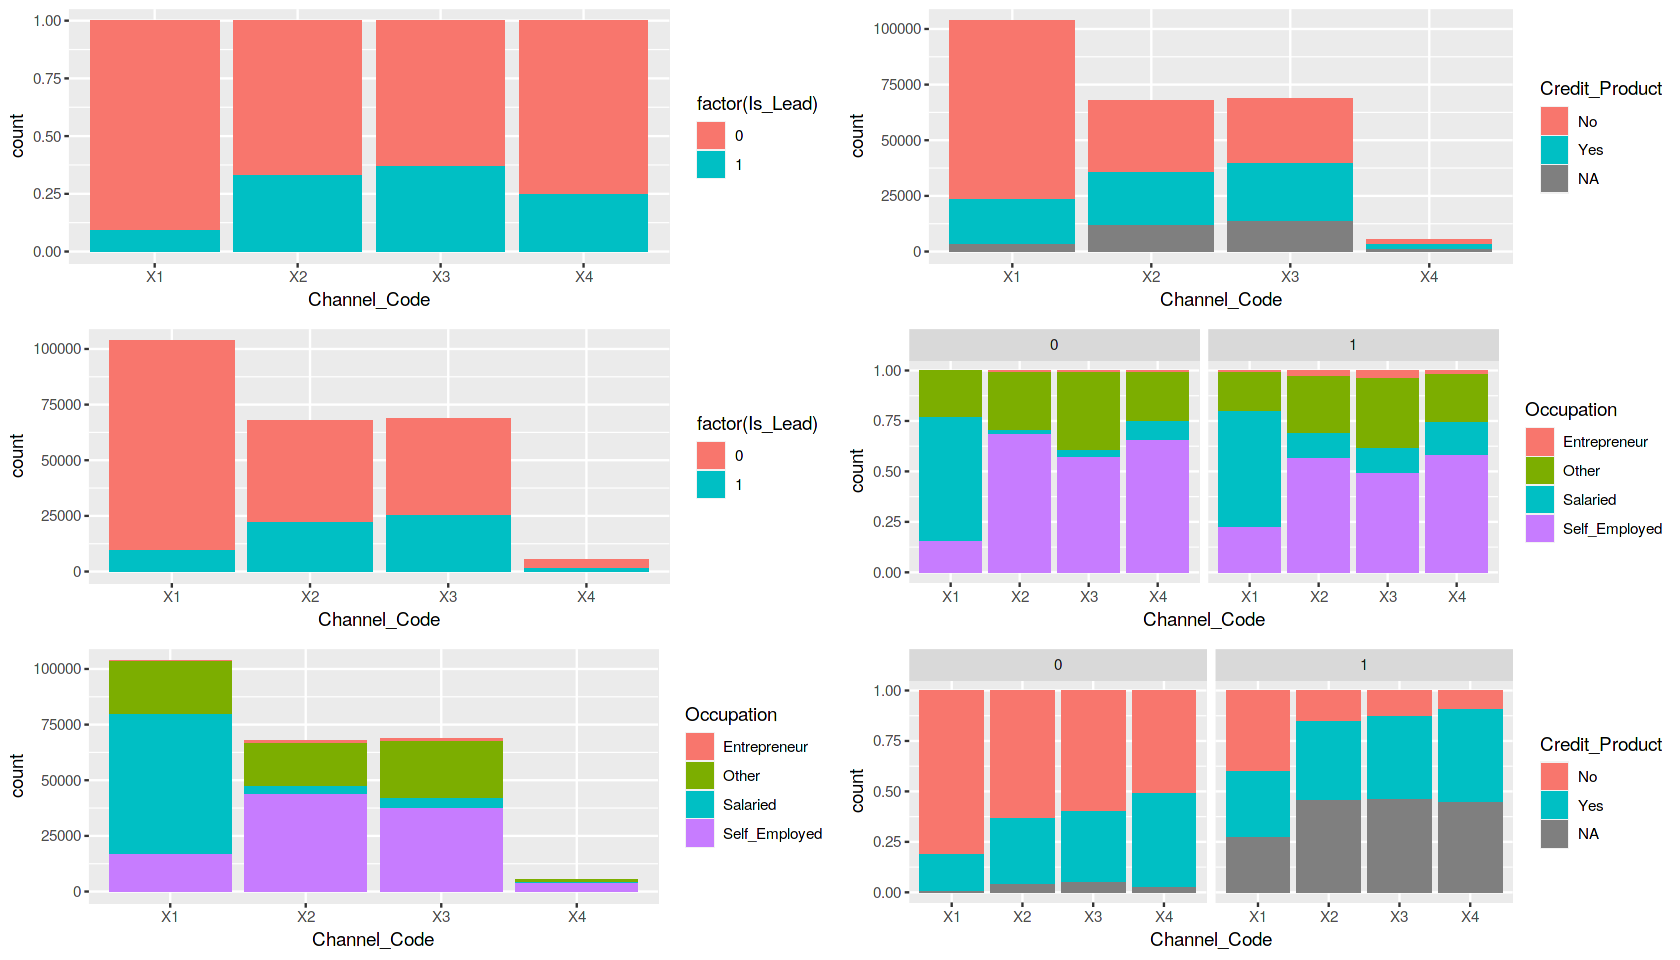

In [6]:
p7 <- train %>% ggplot(aes(Channel_Code,fill=factor(Is_Lead)))+geom_bar(stat="count",position="fill")
p8 <- train %>% ggplot(aes(Channel_Code,fill=factor(Is_Lead)))+geom_bar(stat="count")

p9 <- train %>% ggplot(aes(Channel_Code,fill=Occupation))+geom_bar(stat="count")
p10 <- train %>% ggplot(aes(Channel_Code,fill=Credit_Product))+geom_bar(stat="count")


p11 <- train %>% ggplot(aes(Channel_Code,fill=Occupation))+geom_bar(stat="count",position="fill")+facet_grid(~factor(Is_Lead))
p12 <- train %>% ggplot(aes(Channel_Code,fill=Credit_Product))+geom_bar(stat="count",position="fill")+facet_grid(~factor(Is_Lead))
multiplot(p7,p8,p9,p10,p11,p12, cols=2)

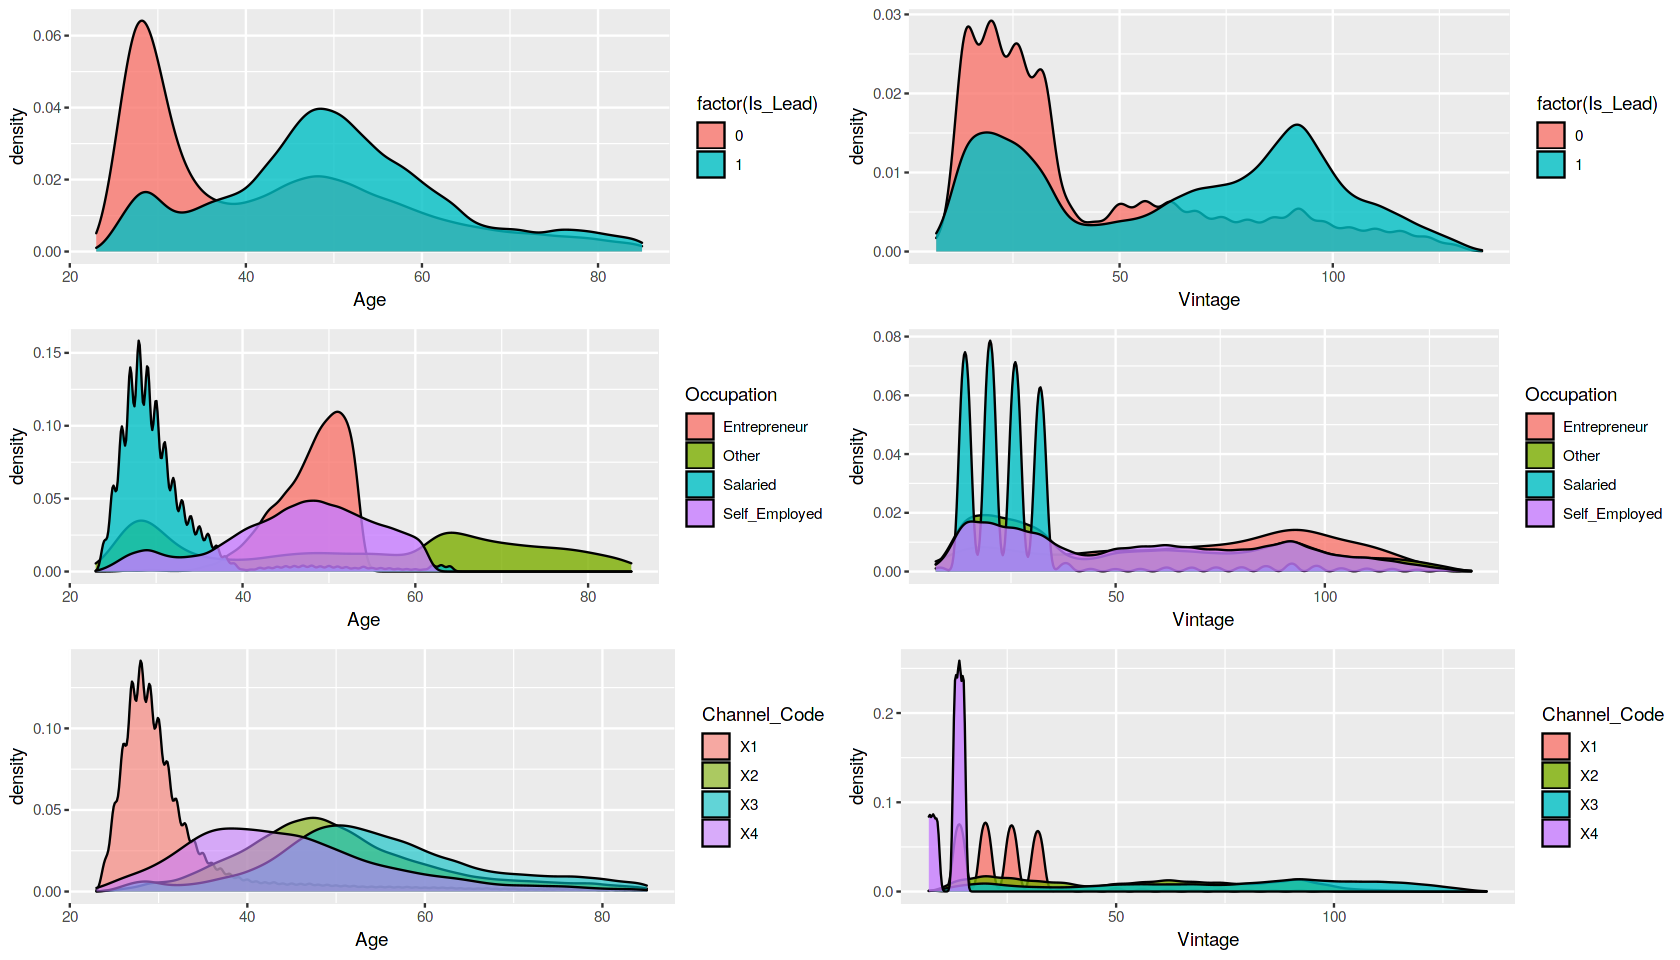

In [7]:
p1 <- train %>% ggplot(aes(Age,fill=factor(Is_Lead)))+geom_density(alpha=0.8) #important
p2 <- train %>% ggplot(aes(Vintage,fill=factor(Is_Lead)))+geom_density(alpha=0.8)#important
p3 <- train %>% ggplot(aes(Age,fill=Occupation))+geom_density(alpha=0.8)#important
p4 <- train %>% ggplot(aes(Vintage,fill=Occupation))+geom_density(alpha=0.8)#important
p5 <- train %>% ggplot(aes(Age,fill=Channel_Code))+geom_density(alpha=0.6)#important
p6 <- train %>% ggplot(aes(Vintage,fill=Channel_Code))+geom_density(alpha=0.8)#important
layout <- matrix(c(1,2,3,4,5,6),3,2,byrow=TRUE)
multiplot(p1, p2, p3, p4, p5, p6, layout = layout)

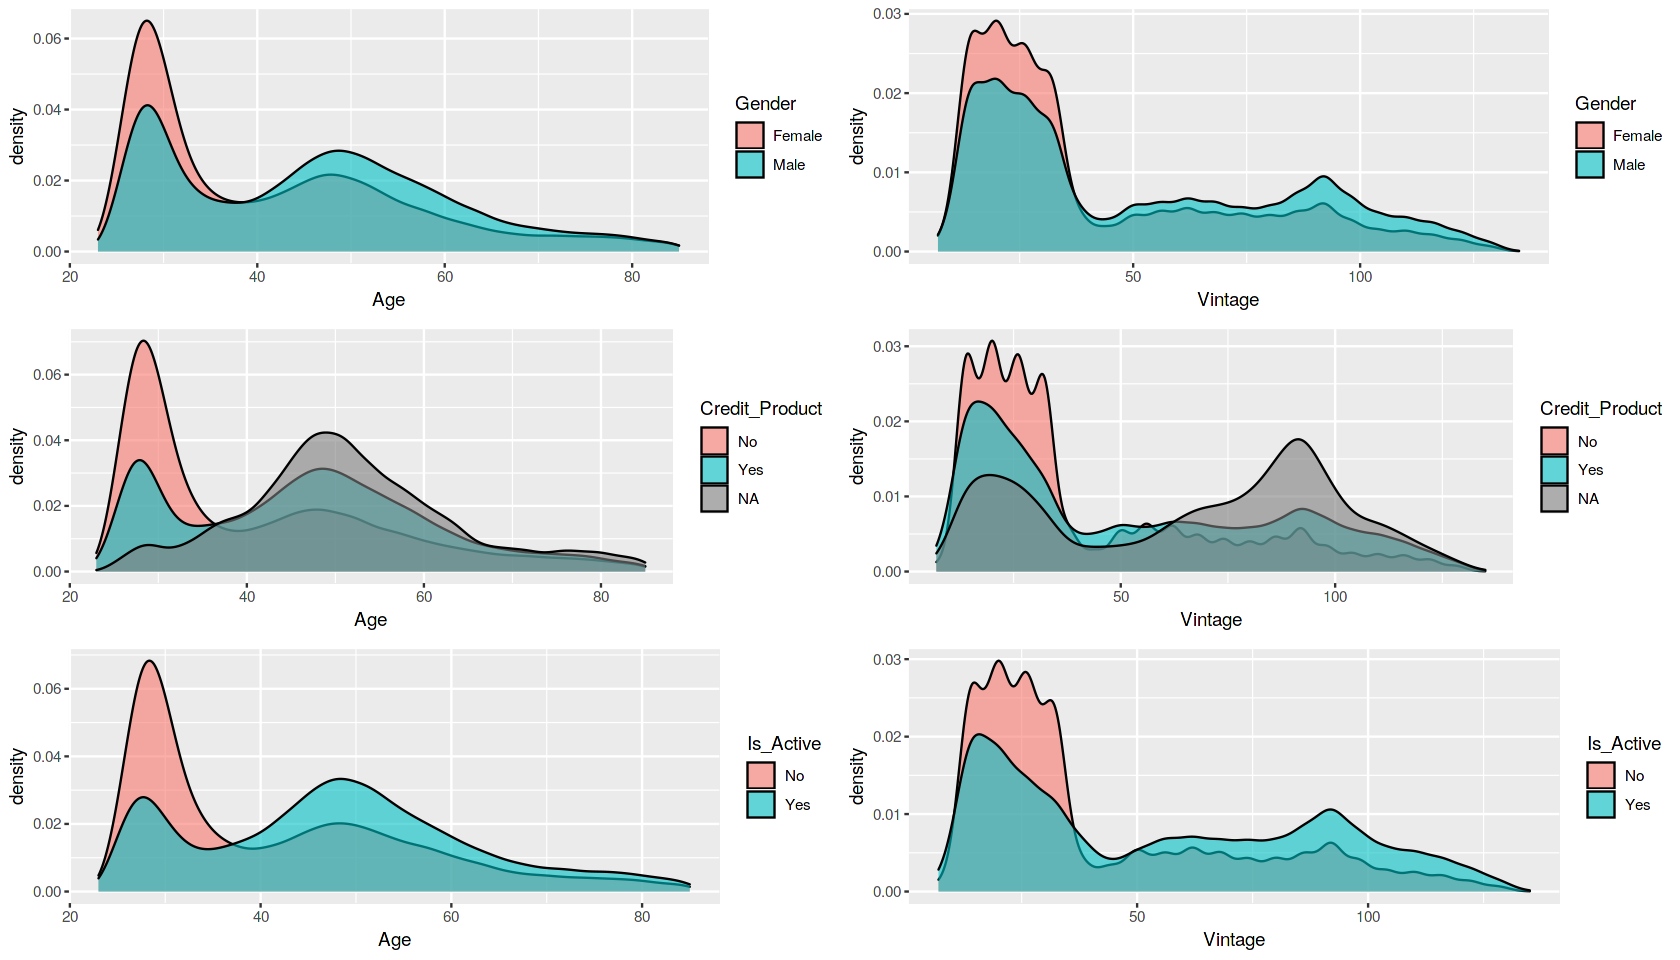

In [8]:
p1 <- train %>% ggplot(aes(Age,fill=Gender))+geom_density(alpha=0.6) #important
p2 <- train %>% ggplot(aes(Vintage,fill=Gender))+geom_density(alpha=0.6)#important
p3 <- train %>% ggplot(aes(Age,fill=Credit_Product))+geom_density(alpha=0.6)#important
p4 <- train %>% ggplot(aes(Vintage,fill=Credit_Product))+geom_density(alpha=0.6)#important
p5 <- train %>% ggplot(aes(Age,fill=Is_Active))+geom_density(alpha=0.6)#important
p6 <- train %>% ggplot(aes(Vintage,fill=Is_Active))+geom_density(alpha=0.6)#important
layout <- matrix(c(1,2,3,4,5,6),3,2,byrow=TRUE)
multiplot(p1, p2, p3, p4, p5, p6, layout = layout)

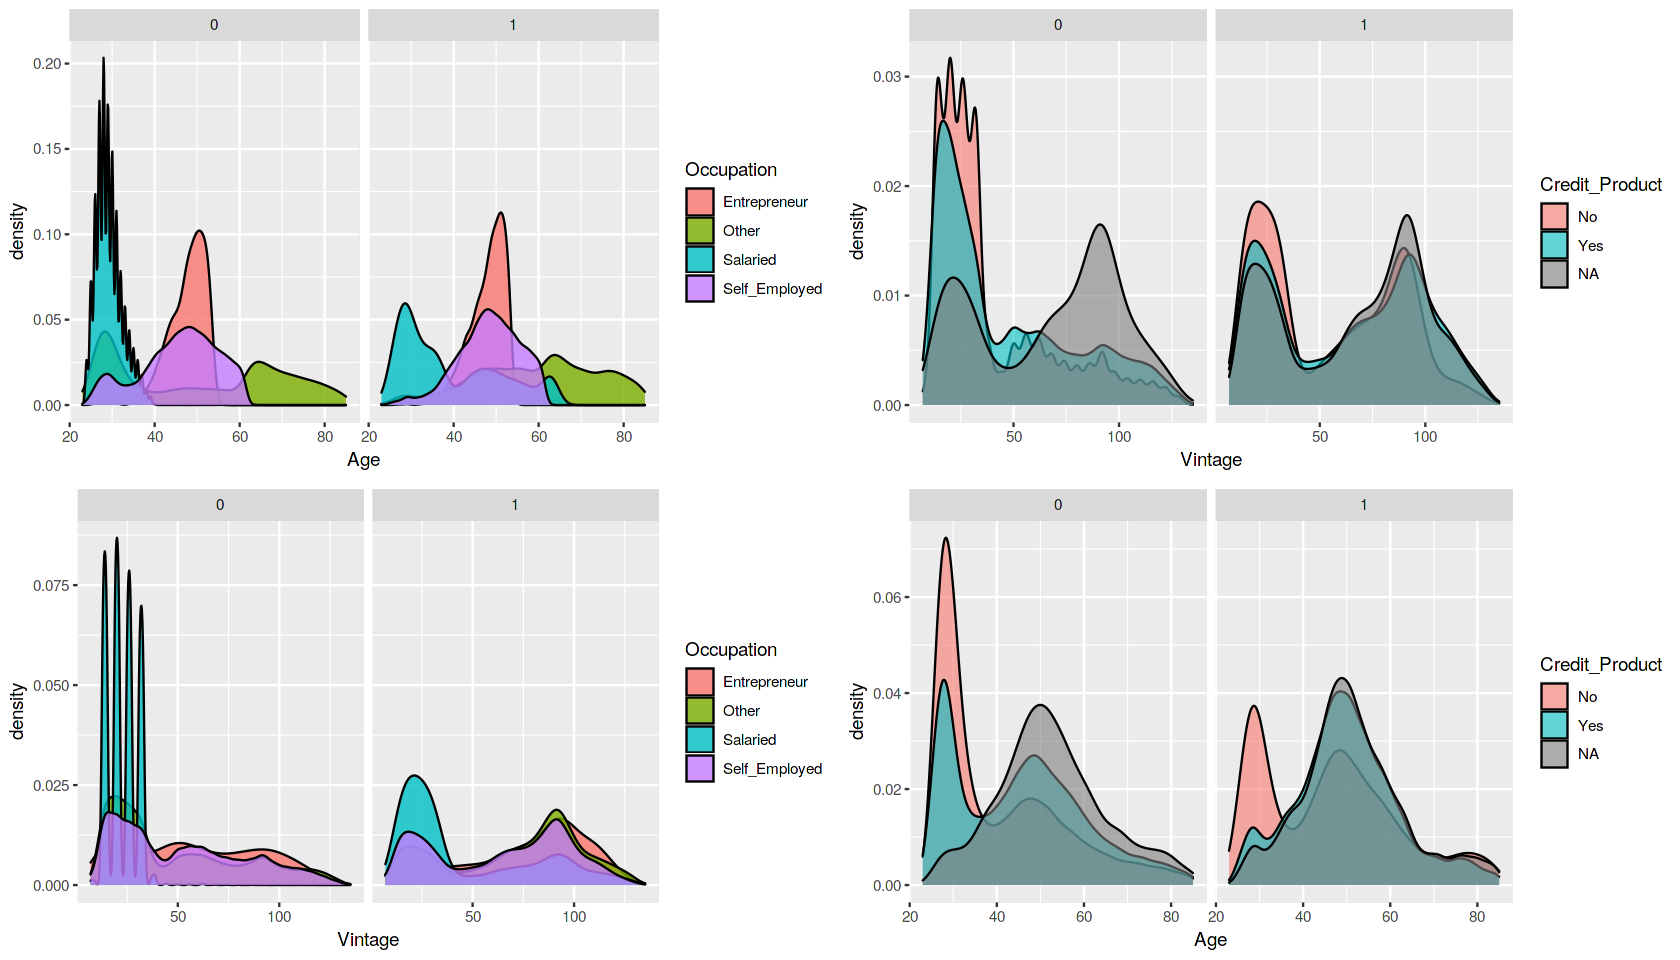

In [9]:
p1 <- train %>% ggplot(aes(Age,fill=Occupation))+geom_density(alpha=0.8)+facet_grid(~factor(Is_Lead))
p2 <- train %>% ggplot(aes(Vintage,fill=Occupation))+geom_density(alpha=0.8)+facet_grid(~factor(Is_Lead))
p3 <- train %>% ggplot(aes(Vintage,fill=Credit_Product))+geom_density(alpha=0.6)+facet_grid(~factor(Is_Lead))#important
p4 <- train %>% ggplot(aes(Age,fill=Credit_Product))+geom_density(alpha=0.6)+facet_grid(~factor(Is_Lead))#important
multiplot(p1, p2, p3, p4, cols=2)

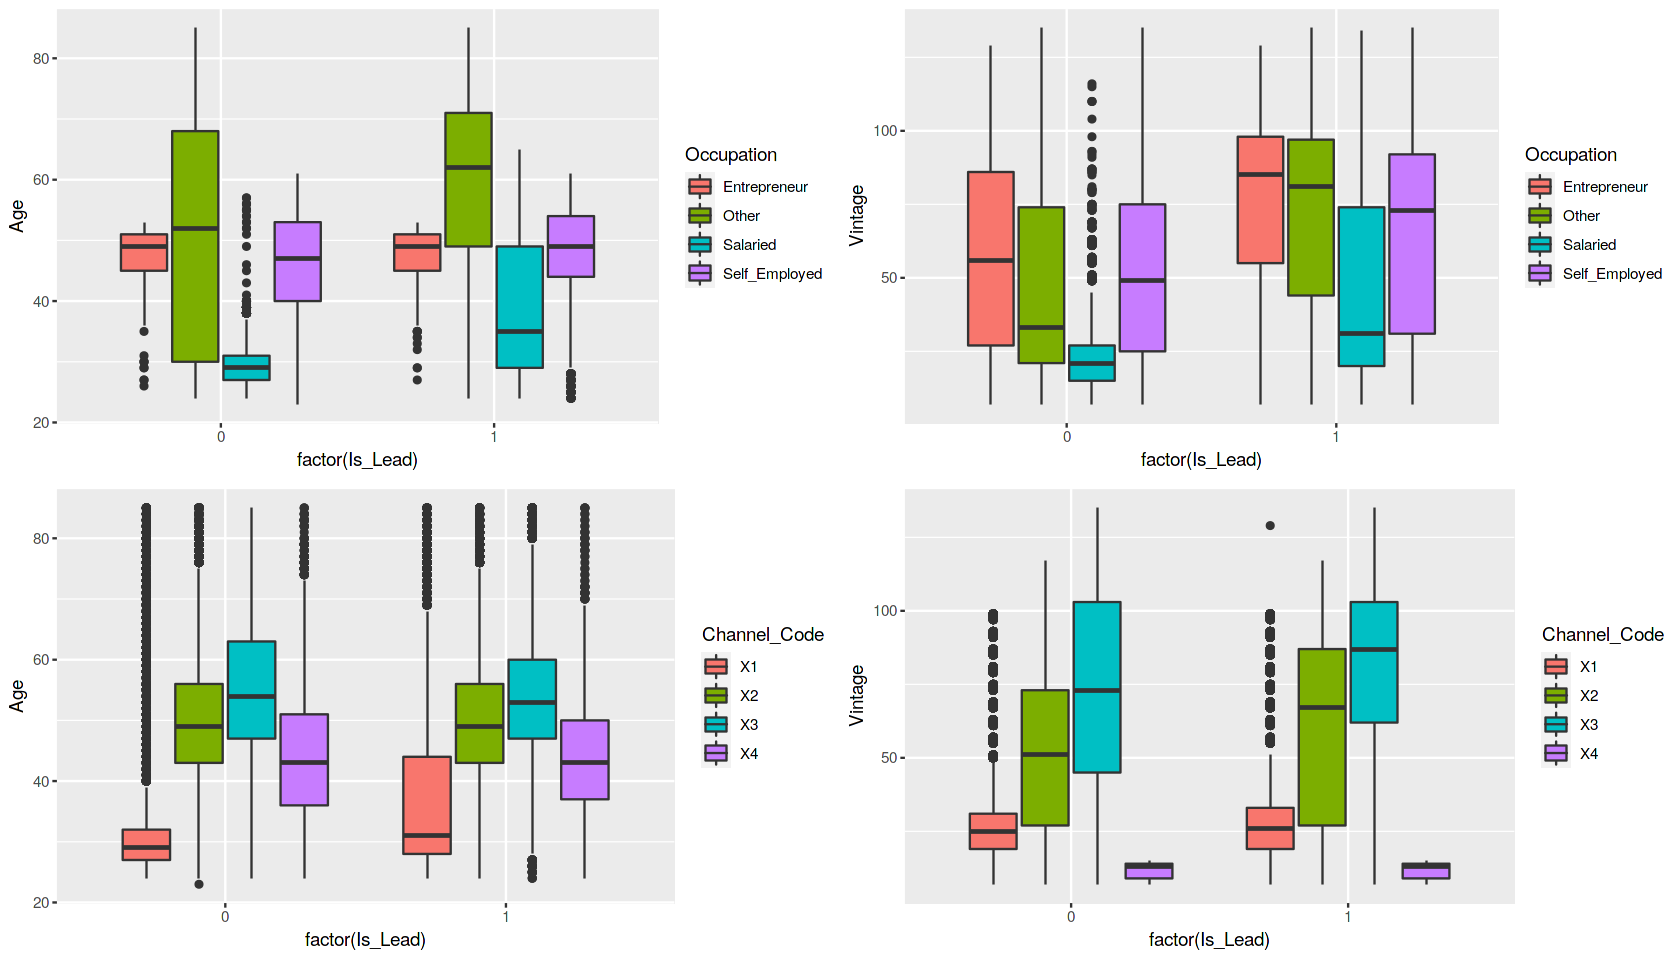

In [10]:
p1 <- train %>% ggplot(aes(factor(Is_Lead),Age,fill=Occupation))+geom_boxplot()#important
p2 <- train %>% ggplot(aes(factor(Is_Lead),Age,fill=Channel_Code))+geom_boxplot()#important
p3 <- train %>% ggplot(aes(factor(Is_Lead),Vintage,fill=Occupation))+geom_boxplot()#important
p4 <- train %>% ggplot(aes(factor(Is_Lead),Vintage,fill=Channel_Code))+geom_boxplot()#important
multiplot(p1, p2, p3, p4, cols=2)

train %>% ggplot(aes(Occupation,Age,fill=factor(Is_Lead)))+geom_violin()
train %>% ggplot(aes(Channel_Code,Age,fill=factor(Is_Lead)))+geom_violin()

# Pre-Processing & Modelling

We will be fixing the missing values in 2 ways,
1. Using missForest
2. Using Recipe baggedImputes
3. Running a smaller model to predict the missing values using lightgbm or catboost or h2o
4. imputing -999

We can fix imbalance class using 
1. SMOTE / ROSE
2. Using the algorithm inbuild way balacing way

In [11]:
train <- train %>% mutate(Is_Lead=factor(Is_Lead))

In [12]:
tr_split <- initial_split(train,prop=0.8,strata = Is_Lead,breaks = 4)
tr_split

<Analysis/Assess/Total>
<196581/49144/245725>

In [13]:
tr_sample <- training(tr_split)
va_sample <- testing(tr_split)
folds <- vfold_cv(tr_sample,v=5)
str(tr_sample)

tibble[,10] [196,581 × 10] (S3: tbl_df/tbl/data.frame)
 $ Gender             : Factor w/ 2 levels "Female","Male": 1 1 1 1 2 2 1 1 2 1 ...
 $ Age                : num [1:196581] 73 30 56 30 56 62 48 40 53 27 ...
 $ Region_Code        : Factor w/ 35 levels "RG250","RG251",..: 19 28 19 33 12 33 16 34 5 28 ...
 $ Occupation         : Factor w/ 4 levels "Entrepreneur",..: 2 3 4 3 4 2 4 4 4 3 ...
 $ Channel_Code       : Factor w/ 4 levels "X1","X2","X3",..: 3 1 3 1 1 3 3 2 3 1 ...
 $ Vintage            : num [1:196581] 43 32 26 33 32 20 13 38 123 20 ...
 $ Credit_Product     : Factor w/ 2 levels "No","Yes": 1 1 1 1 1 NA 1 1 1 1 ...
 $ Avg_Account_Balance: num [1:196581] 1045696 581988 1484315 886787 544163 ...
 $ Is_Active          : Factor w/ 2 levels "No","Yes": 1 1 2 1 2 2 2 1 2 2 ...
 $ Is_Lead            : Factor w/ 2 levels "0","1": 1 1 1 1 1 2 1 1 1 1 ...


In [14]:
#recipe bagged impute
bagg_impute <- tr_sample %>% 
    recipe(Is_Lead~.) %>% 
    step_log(Avg_Account_Balance) %>%
    step_impute_bag(Credit_Product,
                    impute_with = imp_vars(Age,Vintage,Occupation,
                                           Channel_Code),
                   options = list(nbagg = 10, keepX = FALSE))

In [19]:
#conveting the nominal data to one hot encoding and removing the near zero variance
def_bagg_impute <- bagg_impute %>%
    step_dummy(all_nominal(),-all_outcomes()) %>%
    step_nzv(all_predictors())

#creating an ordinal score for the nominal data
ordinal_bag_impute <- bagg_impute %>%
    step_mutate_at(c("Region_Code","Occupation","Gender","Channel_Code","Credit_Product","Is_Active"),fn= as.integer)

#combining with ROSE to handle imbalance
rose_bagg_impute <- def_bagg_impute %>%
    step_rose(Is_Lead)

rose_bagg_ordinal_impute <- ordinal_bag_impute %>%
    step_rose(Is_Lead)

In [33]:
tr_s <- bake(prep(ordinal_bag_impute),new_data = NULL) %>% mutate(Is_Lead=as.numeric(Is_Lead))
str(tr_s)



tibble[,10] [196,581 × 10] (S3: tbl_df/tbl/data.frame)
 $ Gender             : int [1:196581] 1 1 1 1 2 2 1 1 2 1 ...
 $ Age                : num [1:196581] 73 30 56 30 56 62 48 40 53 27 ...
 $ Region_Code        : int [1:196581] 19 28 19 33 12 33 16 34 5 28 ...
 $ Occupation         : int [1:196581] 2 3 4 3 4 2 4 4 4 3 ...
 $ Channel_Code       : int [1:196581] 3 1 3 1 1 3 3 2 3 1 ...
 $ Vintage            : num [1:196581] 43 32 26 33 32 20 13 38 123 20 ...
 $ Credit_Product     : int [1:196581] 1 1 1 1 1 2 1 1 1 1 ...
 $ Avg_Account_Balance: num [1:196581] 13.9 13.3 14.2 13.7 13.2 ...
 $ Is_Active          : int [1:196581] 1 1 2 1 2 2 2 1 2 2 ...
 $ Is_Lead            : num [1:196581] 1 1 1 1 1 2 1 1 1 1 ...


In [34]:
va_s <- bake(prep(ordinal_bag_impute),new_data = va_sample) %>% mutate(Is_Lead=as.numeric(Is_Lead))

In [35]:
te_s <- bake(prep(ordinal_bag_impute),new_data = test)
head(te_s)

Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
<int>,<dbl>,<int>,<int>,<int>,<dbl>,<int>,<dbl>,<int>
2,29,5,2,1,25,2,13.51760,1
2,43,19,2,2,49,1,13.73813,1
2,31,21,3,1,14,1,12.28280,1
2,29,23,2,1,33,1,13.67403,1
1,29,21,2,1,19,1,13.39557,1
2,60,19,4,3,110,1,15.34683,1


In [36]:
full_tr <- bake(prep(rose_bagg_ordinal_impute),new_data = train) %>% mutate(Is_Lead=as.numeric(Is_Lead))

Preparing the dataset for LGBM / CATBOOST / H2O

In [37]:
X2 <- colnames(te_s)
# cat_features2 <- names(Filter(is.factor,te_s[,X2]))
cat_features <- X2[-c(2,6,8)]
#lets run a catboost to check the facts 
Y <- "Is_Lead"
X2
cat_features

[1] "Gender"              "Age"                 "Region_Code"        
[4] "Occupation"          "Channel_Code"        "Vintage"            
[7] "Credit_Product"      "Avg_Account_Balance" "Is_Active"

[1] "Gender"         "Region_Code"    "Occupation"     "Channel_Code"  
[5] "Credit_Product" "Is_Active"

In [38]:
#Creating Catboost data
tr_pool <- catboost.load_pool(data =  tr_s[,X2],label = unlist(tr_s[,Y]),cat_features=cat_features)
va_pool <- catboost.load_pool(data =  va_s[,X2],label = unlist(va_s[,Y]),cat_features=cat_features)
te_pool <- catboost.load_pool(data =  te_s[,X2],cat_features=cat_features)
fill_tr <- catboost.load_pool(data =  full_tr[,X2],label = unlist(full_tr[,Y]),cat_features=cat_features)

In [41]:
params <- list(iterations=10000,
               learning_rate=0.01,
               depth=8,
               loss_function="Logloss",
               eval_metric='AUC',
               random_seed = 55,
               l2_leaf_reg=10,
               auto_class_weights = "Balanced",
               od_type='Iter',
               metric_period = 50,
               od_wait=20,
               use_best_model=TRUE)

In [42]:
model_train <- catboost.train(tr_pool,va_pool,params=params)

0:	test: 0.7689760	best: 0.7689760 (0)	total: 79.5ms	remaining: 13m 14s
50:	test: 0.7893599	best: 0.7894043 (49)	total: 3.43s	remaining: 11m 9s
100:	test: 0.7907982	best: 0.7907982 (100)	total: 6.76s	remaining: 11m 2s
150:	test: 0.7925662	best: 0.7925662 (150)	total: 10.1s	remaining: 10m 56s
200:	test: 0.7940481	best: 0.7940481 (200)	total: 13.1s	remaining: 10m 37s
250:	test: 0.7949134	best: 0.7949134 (250)	total: 16.1s	remaining: 10m 24s
300:	test: 0.7954327	best: 0.7954327 (300)	total: 19.1s	remaining: 10m 16s
350:	test: 0.7958024	best: 0.7958024 (350)	total: 22.4s	remaining: 10m 15s
400:	test: 0.7961739	best: 0.7961739 (400)	total: 25.5s	remaining: 10m 9s
450:	test: 0.7964111	best: 0.7964111 (450)	total: 28.6s	remaining: 10m 5s
500:	test: 0.7965828	best: 0.7965828 (500)	total: 31.8s	remaining: 10m 2s
550:	test: 0.7968001	best: 0.7968006 (549)	total: 34.8s	remaining: 9m 56s
600:	test: 0.7969591	best: 0.7969591 (600)	total: 37.9s	remaining: 9m 52s
650:	test: 0.7971464	best: 0.7971464 

In [45]:
#feature importance
feat_imp <- as_tibble(catboost.get_feature_importance(model_train))%>% 
    rownames_to_column() %>% cbind(.,X2) %>% arrange(desc(V1))
feat_imp

rowname,V1,X2
<chr>,<dbl>,<fct>
4,51.5190645,Occupation
2,12.4072883,Age
6,11.8386238,Vintage
7,10.5950260,Credit_Product
5,5.7213366,Channel_Code
9,4.0182471,Is_Active
3,1.6836448,Region_Code
8,1.5086322,Avg_Account_Balance
1,0.7081367,Gender


In [50]:
va_pred_class <- catboost.predict(model_train, 
                               va_pool, 
                               prediction_type = 'Class')
va_pred_prob <-  catboost.predict(model_train, 
                               va_pool, 
                               prediction_type = 'Probability')

In [55]:
confusionMatrix(factor(va_s$Is_Lead-1),factor(va_pred_class))

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 27053 10434
         1  3086  8571
                                          
               Accuracy : 0.7249          
                 95% CI : (0.7209, 0.7288)
    No Information Rate : 0.6133          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.3754          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.8976          
            Specificity : 0.4510          
         Pos Pred Value : 0.7217          
         Neg Pred Value : 0.7353          
             Prevalence : 0.6133          
         Detection Rate : 0.5505          
   Detection Prevalence : 0.7628          
      Balanced Accuracy : 0.6743          
                                          
       'Positive' Class : 0               
                  

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Warning message in plot.ci.se(sens.ci, type = "shape", col = "lightblue"):
“Low definition shape.”


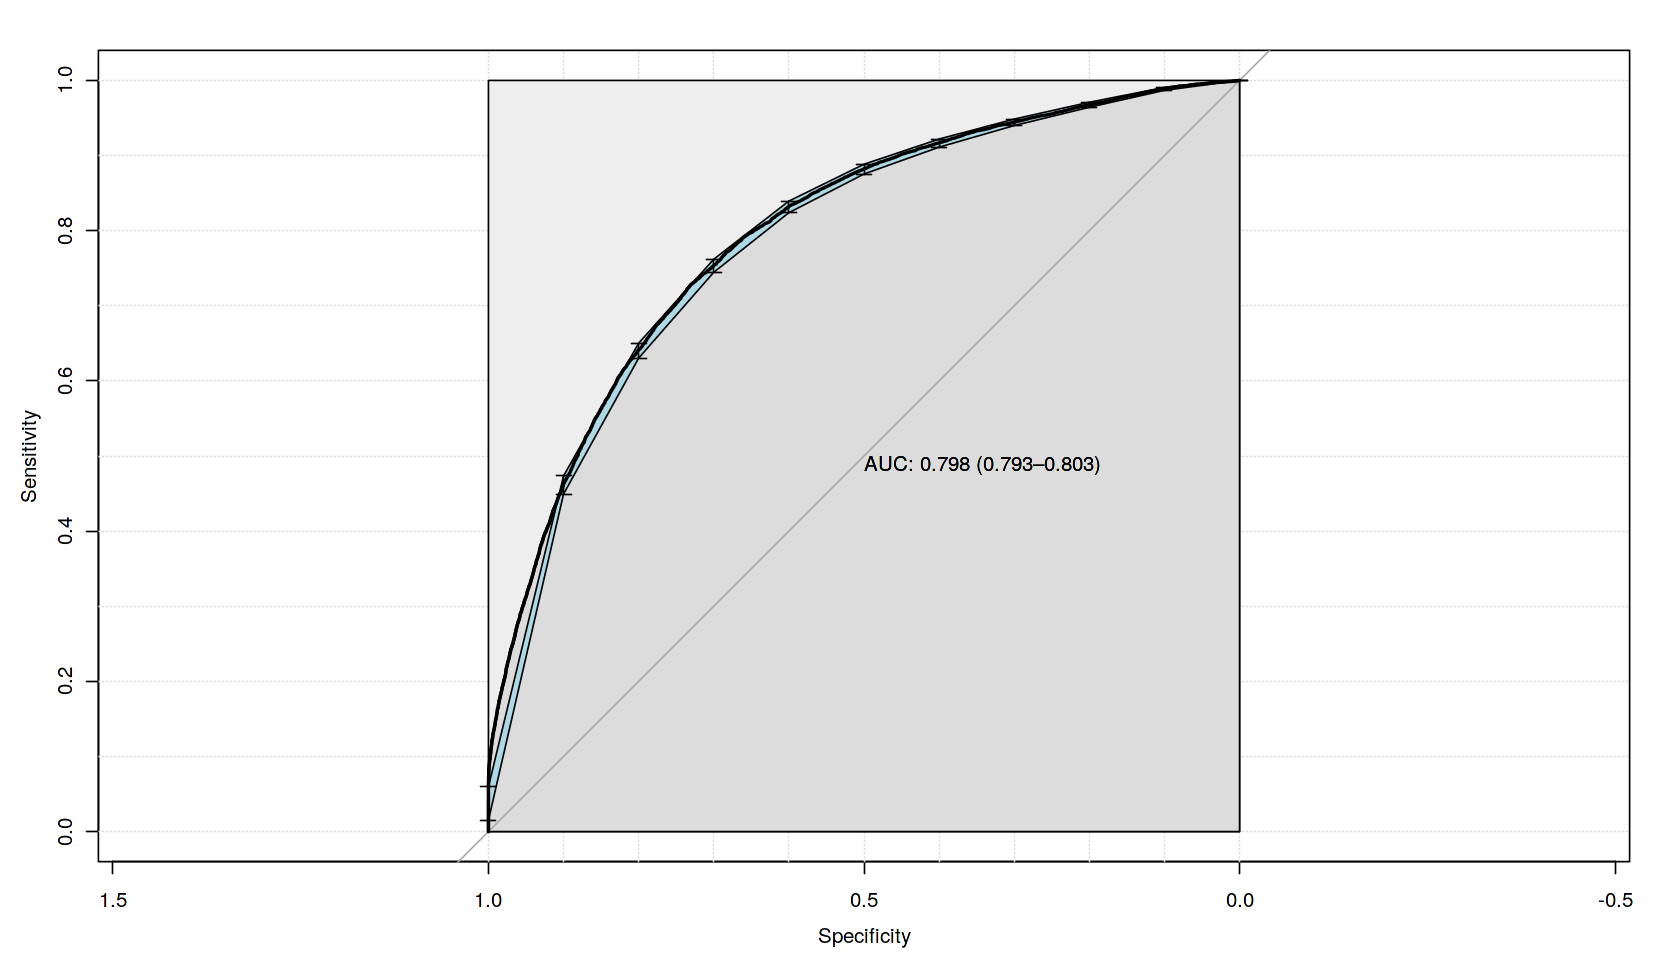

In [57]:
pROC_obj <- roc(va_s$Is_Lead-1,va_pred_prob,
            smoothed = TRUE,
            # arguments for ci
            ci=TRUE, ci.alpha=0.9, stratified=FALSE,
            # arguments for plot
            plot=TRUE, auc.polygon=TRUE, max.auc.polygon=TRUE, grid=TRUE,
            print.auc=TRUE, show.thres=TRUE)


sens.ci <- ci.se(pROC_obj)
plot(sens.ci, type="shape", col="lightblue")
## Warning in plot.ci.se(sens.ci, type = "shape", col = "lightblue"): Low
## definition shape.
plot(sens.ci, type="bars")

In [58]:
params_f <- list(iterations=1206,
               learning_rate=0.01,
               depth=8,
               loss_function="Logloss",
               eval_metric='AUC',
               random_seed = 55,
               l2_leaf_reg=10,
               auto_class_weights = "Balanced",
               od_type='Iter',
               metric_period = 50,
               od_wait=20)
model_final_train <- catboost.train(fill_tr,params = params_f)

0:	total: 93.5ms	remaining: 1m 52s
50:	total: 3.69s	remaining: 1m 23s
100:	total: 7.26s	remaining: 1m 19s
150:	total: 10.8s	remaining: 1m 15s
200:	total: 14.3s	remaining: 1m 11s
250:	total: 17.6s	remaining: 1m 6s
300:	total: 21s	remaining: 1m 3s
350:	total: 24.6s	remaining: 59.9s
400:	total: 28.1s	remaining: 56.4s
450:	total: 31.7s	remaining: 53s
500:	total: 35s	remaining: 49.2s
550:	total: 38.5s	remaining: 45.8s
600:	total: 42s	remaining: 42.3s
650:	total: 45.5s	remaining: 38.8s
700:	total: 49s	remaining: 35.3s
750:	total: 52.6s	remaining: 31.9s
800:	total: 56.4s	remaining: 28.5s
850:	total: 60s	remaining: 25s
900:	total: 1m 3s	remaining: 21.5s
950:	total: 1m 6s	remaining: 17.9s
1000:	total: 1m 10s	remaining: 14.4s
1050:	total: 1m 13s	remaining: 10.9s
1100:	total: 1m 17s	remaining: 7.34s
1150:	total: 1m 20s	remaining: 3.85s
1200:	total: 1m 23s	remaining: 349ms
1205:	total: 1m 24s	remaining: 0us


In [59]:
#test prediction
te_pred <- catboost.predict(model_train, 
                               te_pool, 
                               prediction_type = 'Probability')

In [60]:
#creating submission
submission <- data.frame('ID'=sample_sub$ID,'Is_Lead'=te_pred)
filename <- paste('catboost_1206_bag_impute',format(Sys.time(),"%Y%m%d%H%M%s"),sep = '_')
write.csv(submission,paste0(filename,'.csv',collapse = ''),row.names = FALSE)

In [61]:
te_just <- catboost.predict(model_train, 
                               te_pool, 
                               prediction_type = 'Class')
submission <- data.frame('ID'=sample_sub$ID,'Is_Lead'=te_just)
filename <- paste('catboost_1206_bag_impute_clss',format(Sys.time(),"%Y%m%d%H%M%s"),sep = '_')
write.csv(submission,paste0(filename,'.csv',collapse = ''),row.names = FALSE)

In [ ]:
h2o.init()

In [ ]:
#h20
tr_dd <- as.h2o(tr_s)
va_dd <- as.h2o(va_s)
te_dd <- as.h2o(te_s)

X <- colnames(te_s)
Y <- "Is_Lead"
X

In [ ]:
almname <- paste('ak_h2o_automl',format(Sys.time(),"%d%H%M%S"),sep = '_')
autoML <- h2o.automl(X,Y,training_frame = tr_dd,
                     validation_frame = va_dd,seed=223, 
                     max_models=10,stopping_metric=c("AUC"),balance_classes=TRUE)

In [ ]:
autoML@leader

In [ ]:
autoML@leaderboard

In [ ]:
leader_name <- as.tibble(autoML@leaderboard) %>% dplyr::slice(1) %>% dplyr::pull(model_id)

leader_model <- h2o.getModel(leader_name)

save(autoML, file="automlv1_20210528.rda")

In [ ]:
leader_model@parameters

In [ ]:
pref <- h2o.performance(leader_model,tr_dd)
plot(pref,type="roc")
pref

In [ ]:
pref <- h2o.performance(leader_model,va_dd)
plot(pref,type="roc")
pref

In [ ]:
yhat <- h2o.predict(leader_model,te_dd) %>% as_tibble()
summary(yhat)

In [ ]:
submission <- data.frame('ID'=sample_sub$ID,'Is_Lead'=yhat$p1)
filename <- paste('ak_h2o_20_automl_bag_imp_nvz_dummy',format(Sys.time(),"%Y%m%d%H%M%s"),sep = '_')
write.csv(submission,paste0(filename,'.csv',collapse = ''),row.names = FALSE)

In [ ]:
tr_s <- bake(prep(bagg_impute),new_data = NULL)
va_s <- bake(prep(bagg_impute),new_data = va_sample)
te_s <- bake(prep(bagg_impute),new_data = test)

In [ ]:
str(tr_s)

In [ ]:
tr_dd <- as.h2o(tr_s)
va_dd <- as.h2o(va_s)
te_dd <- as.h2o(te_s)

X <- colnames(te_s)
Y <- "Is_Lead"
X

In [ ]:
almname <- paste('ak_h2o_automl',format(Sys.time(),"%d%H%M%S"),sep = '_')
autoML <- h2o.automl(X,Y,training_frame = tr_dd,
                     validation_frame = va_dd,seed=223, 
                     max_models=10,stopping_metric=c("AUC"),balance_classes=TRUE)

In [ ]:
autoML@leader

In [ ]:
autoML@leaderboard

In [ ]:
leader_name <- as.tibble(autoML@leaderboard) %>% dplyr::slice(1) %>% dplyr::pull(model_id)

leader_model <- h2o.getModel(leader_name)

save(autoML, file="automlv2_20210528.rda")

In [ ]:
pref <- h2o.performance(leader_model,tr_dd)
plot(pref,type="roc")
pref

In [ ]:
pref <- h2o.performance(leader_model,va_dd)
plot(pref,type="roc")
pref

In [ ]:
yhat <- h2o.predict(leader_model,te_dd) %>% as_tibble()
summary(yhat)

In [ ]:
submission <- data.frame('ID'=sample_sub$ID,'Is_Lead'=yhat$p1)
filename <- paste('ak_h2o_20_automl_bag_imp',format(Sys.time(),"%Y%m%d%H%M%s"),sep = '_')
write.csv(submission,paste0(filename,'.csv',collapse = ''),row.names = FALSE)